# Repeat Running Mode

Another simple but powerful function provided in ``BrainPy`` is the repeat running mode of ``brainpy.Network``. This function allows users to run a compiled network model repetitively. Specifically, each ``brainpy.Network`` is instantiated in the repeat mode by default. The parameters and the variables in the step functions can be arbitrarily changed without the need to recompile the network models.

Repeat mode of ``brainpy.Network`` is very useful at least in the following two situations: *parameter searching* and *RAM memory saving*.

## Parameter Searching

``Parameter searching`` is one of the most common things in computational modeling. When creating a 
model, we'll be presented with many parameters to control how our defined model evolves. Often times, 
we don't immediately know what the optimal parameter set should be for a given model, and thus we'd 
like to be able to explore a range of possibilities. 

Fortunately, with the ``repeat`` mode provided in ``brainpy.Network``, parameter searching is a very easy thing. 

Here, we illustrate this with the example of [gamma oscillation](https://brainmodels.readthedocs.io/en/latest/from_papers/Wang_1996_gamma_oscillation.html), and to see how different value of ``g_max`` (the maximal synaptic conductance) affect the network coherence. 

First, let's import the necessary packages and define the models first.

In [1]:
import brainpy as bp

import numpy as np
import matplotlib.pyplot as plt

In [2]:
bp.backend.set('numba', dt=0.04)
bp.integrators.set_default_odeint('exponential_euler')

We first define the HH neuron model:

In [3]:
# Neuron Group #
# ------------ #

class HH(bp.NeuGroup):
    target_backend = 'general'

    def __init__(self, size, ENa=55., EK=-90., EL=-65,
                 C=1.0, gNa=35., gK=9., gL=0.1, V_th=20.,
                 phi=5.0, **kwargs):
        super(HH, self).__init__(size=size, **kwargs)
        
        # parameters
        self.ENa = ENa
        self.EK = EK
        self.EL = EL
        self.C = C
        self.gNa = gNa
        self.gK = gK
        self.gL = gL
        self.V_th = V_th
        self.phi = phi

        # variables
        self.V = bp.ops.ones(self.num) * -65.
        self.h = bp.ops.ones(self.num) * 0.6
        self.n = bp.ops.ones(self.num) * 0.32
        self.spike = bp.ops.zeros(self.num, dtype=bool)
        self.input = bp.ops.zeros(self.num)

    def reset(self):
        self.V[:] = -70. + np.random.random(self.num) * 20

        h_alpha = 0.07 * np.exp(-(self.V + 58) / 20)
        h_beta = 1 / (np.exp(-0.1 * (self.V + 28)) + 1)
        self.h[:] = h_alpha / (h_alpha + h_beta)

        n_alpha = -0.01 * (self.V + 34) / (np.exp(-0.1 * (self.V + 34)) - 1)
        n_beta = 0.125 * np.exp(-(self.V + 44) / 80)
        self.n[:] = n_alpha / (n_alpha + n_beta)

        self.spike[:] = False
        self.input[:] = 0.

    @staticmethod
    @bp.odeint
    def integral(V, h, n, t, Iext, gNa, ENa, gK, EK, gL, EL, C, phi):
        alpha = 0.07 * bp.ops.exp(-(V + 58) / 20)
        beta = 1 / (bp.ops.exp(-0.1 * (V + 28)) + 1)
        dhdt = phi * (alpha * (1 - h) - beta * h)

        alpha = -0.01 * (V + 34) / (bp.ops.exp(-0.1 * (V + 34)) - 1)
        beta = 0.125 * bp.ops.exp(-(V + 44) / 80)
        dndt = phi * (alpha * (1 - n) - beta * n)

        m_alpha = -0.1 * (V + 35) / (bp.ops.exp(-0.1 * (V + 35)) - 1)
        m_beta = 4 * bp.ops.exp(-(V + 60) / 18)
        m = m_alpha / (m_alpha + m_beta)
        INa = gNa * m ** 3 * h * (V - ENa)
        IK = gK * n ** 4 * (V - EK)
        IL = gL * (V - EL)
        dVdt = (- INa - IK - IL + Iext) / C

        return dVdt, dhdt, dndt

    def update(self, _t):
        V, h, n = self.integral(self.V, self.h, self.n, _t,
                                self.input, self.gNa, self.ENa, self.gK,
                                self.EK, self.gL, self.EL, self.C, self.phi)
        self.spike = np.logical_and(self.V < self.V_th, V >= self.V_th)
        self.V = V
        self.h = h
        self.n = n
        self.input[:] = 0

Then, the inter-connected synapse GABAA can be defined as:

In [4]:
# GABAa Synapse #
# ------------- #

class GABAa(bp.TwoEndConn):
    target_backend = ['numpy', 'numba']

    def __init__(self, pre, post, conn, delay=0., E=-75., g_max=0.1,
                 alpha=12., beta=0.1, T=1.0, T_duration=1.0, **kwargs):
        # parameters
        self.E = E
        self.alpha = alpha
        self.beta = beta
        self.T = T
        self.T_duration = T_duration
        self.delay = delay
        self.g_max = g_max

        # connections
        self.conn = conn(pre.size, post.size)
        self.conn_mat = self.conn.requires('conn_mat')
        self.num = bp.ops.shape(self.conn_mat)

        # variables
        self.s = bp.ops.zeros(self.num)
        self.t_last_pre_spike = bp.ops.ones(self.num) * -1e7
        self.g = self.register_constant_delay('g', size=self.num, delay_time=delay)
        
        super(GABAa, self).__init__(pre=pre, post=post, **kwargs)

    def reset(self):
        self.s[:] = 0.
        self.t_last_pre_spike[:] = -1e7
        self.g.reset()

    @staticmethod
    @bp.odeint
    def int_s(s, t, TT, alpha, beta):
        dsdt = alpha * TT * (1 - s) - beta * s
        return dsdt

    def update(self, _t):
        for i in range(self.pre.size[0]):
            if self.pre.spike[i] > 0:
                self.t_last_pre_spike[i] = _t
        TT = ((_t - self.t_last_pre_spike) < self.T_duration) * self.T
        self.s = self.int_s(self.s, _t, TT, self.alpha, self.beta)
        self.g.push(self.g_max * self.s)
        g = self.g.pull()
        self.post.input -= bp.ops.sum(g, axis=0) * (self.post.V - self.E)

Putting the HH neuron and the GABA<sub>A</sub> syanpse together, let's define the network in which HH neurons are interconnected with the GABA<sub>A</sub> syanpses. 

In [5]:
# Network #
# ------- #

num = 100

group = HH(num, monitors=['spike', 'V'])
conn = GABAa(pre=group, post=group, g_max=0.1/num, 
             conn=bp.connect.All2All(include_self=False))
net = bp.Network(group, conn)

Now, by using the [cross correlation](https://en.wikipedia.org/wiki/Cross-correlation) measurement, we can evaluate the network coherence under the different parameter setting of ``g_max``.

In [6]:
# Parameter Searching #
# ------------------- #

all_g_max = np.arange(0.05, 0.151, 0.01) / num
all_cc = []

for i, g_max in enumerate(all_g_max):
    print('When g_max = {:.5f} ...'.format(g_max))
    
    group.reset()
    conn.reset()

    net.run(duration=500., inputs=[group, 'input', 1.2], report=True, report_percent=1.)

    cc = bp.measure.cross_correlation(group.mon.spike, bin=0.5)
    all_cc.append(cc)

When g_max = 0.00050 ...
Compilation used 5.6063 s.
Start running ...
Run 100.0% used 1.334 s.
Simulation is done in 1.334 s.

When g_max = 0.00060 ...
Compilation used 0.0000 s.
Start running ...
Run 100.0% used 1.332 s.
Simulation is done in 1.332 s.

When g_max = 0.00070 ...
Compilation used 0.0000 s.
Start running ...
Run 100.0% used 1.353 s.
Simulation is done in 1.353 s.

When g_max = 0.00080 ...
Compilation used 0.0000 s.
Start running ...
Run 100.0% used 1.373 s.
Simulation is done in 1.373 s.

When g_max = 0.00090 ...
Compilation used 0.0000 s.
Start running ...
Run 100.0% used 1.354 s.
Simulation is done in 1.354 s.

When g_max = 0.00100 ...
Compilation used 0.0000 s.
Start running ...
Run 100.0% used 1.358 s.
Simulation is done in 1.358 s.

When g_max = 0.00110 ...
Compilation used 0.0010 s.
Start running ...
Run 100.0% used 1.364 s.
Simulation is done in 1.364 s.

When g_max = 0.00120 ...
Compilation used 0.0000 s.
Start running ...
Run 100.0% used 1.352 s.
Simulation is do

As you can see, the network was only compiled at the fist time run. And the overall speed of the later running does not change.

Finally, we can plot the relationship between the ``g_max`` and network coherence ``cc``.

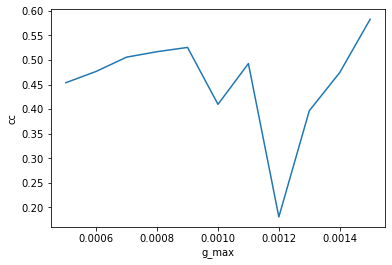

In [7]:
plt.plot(all_g_max, all_cc)
plt.xlabel('g_max')
plt.ylabel('cc')
plt.show()

It is worthy to note that in this example, before each ``net.run()``, we reset the variable state of the neuron group and the synaptic connection. This is because each repeat run is independent with each other in the case of the parameter tuning. However, in the following example, the current ``net.run()`` relies on the previous network running, the variable state should not be reset. 

## Memory Saving

Another annoyance often occurs is that our computers have limited RAM memory. Once the model size is big, or the running duration is long, ``MemoryError`` usually occurs. 

Here, with ``brainpy.Network`` repeat running mode, BrainPy can partially solve this problem by allowing uers to split a long duration into multiple short durations. BrainPy allows user to repeatedly call ``run()``. In this section, we illustrate this function by using the above defined gamma oscillation network.

We define a network with the size of 200 HH neurons, and try to run this network in 2 seconds.

In [8]:
group2 = HH(200, monitors=['spike', 'V'])
group2.reset()

conn2 = GABAa(pre=group2, post=group2, g_max=0.1/200,
              conn=bp.connect.All2All(include_self=False))
net2 = bp.Network(group2, conn2)

Here, we do not run the total 1.5 second at one time. On the contrary, we run the model with four steps, with each step of 0.5 second running duration.

Compilation used 2.1291 s.
Start running ...
Run 50.0% used 2.095 s.
Run 100.0% used 4.187 s.
Simulation is done in 4.187 s.



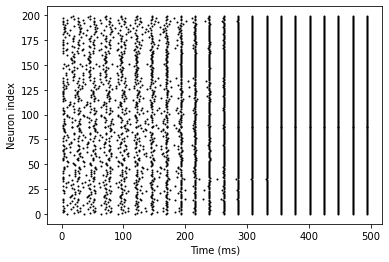

In [9]:
# run 1: 0 - 500 ms

net2.run(duration=(0., 500.), inputs=[group2, 'input', 1.2], report=True, report_percent=0.5)
bp.visualize.raster_plot(group2.mon.spike_t, group2.mon.spike, show=True)

Compilation used 0.0000 s.
Start running ...
Run 50.0% used 2.128 s.
Run 100.0% used 4.249 s.
Simulation is done in 4.249 s.



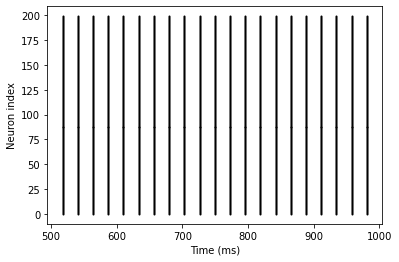

In [10]:
# run 2: 500 - 1000 ms

net2.run(duration=(500., 1000.), inputs=[group2, 'input', 1.2], report=True, report_percent=0.5)
bp.visualize.raster_plot(group2.mon.spike_t, group2.mon.spike, show=True)

Set a different inputs structure (the previous is a "float", now it's a vector), the network will rebuild the input function and run the network continuously.

Compilation used 0.0010 s.
Start running ...
Run 50.0% used 2.134 s.
Run 100.0% used 4.284 s.
Simulation is done in 4.284 s.



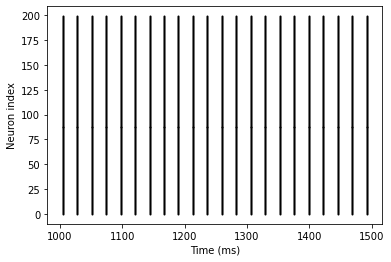

In [11]:
# run 1000 - 1500 ms

Iext = np.ones(group2.num) * 1.2
net2.run(duration=(1000., 1500.), inputs=[group2, 'input', Iext],
        report=True, report_percent=0.5)
bp.visualize.raster_plot(group2.mon.spike_t, group2.mon.spike, show=True)

---

**NOTE**


Another thing worthy noting is that if the model variable states rely on the time (for example, the LIF neuron model ``self.t_last_spike``). Setting the continuous time duration between each repeat run is necessary, because the model's logic is dependent on the current time ``_t``. 


**Author**:

- Chaoming Wang
- Email: adaduo@outlook.com
- Date: 2021.05.25

---
